### Hohmann transfer orbit

So far, we've seen the general dynamics of the two-body and three-body problems. Now, we're going to see an orbital maneuver which is truly important when designing interplanetary travels. In fact, we're talking about the **Hohmann transfer orbit**. 

The Hohmann transfer orbit is an elliptical orbit designed to transfer between two different circular orbits around a central body in the same plane. It's usually the most efficient way (fuel-efficient) to transfer a spacecraft from one orbit into another. The Hohmann transfer orbit consists on **two impulses**: one to move the spacecraft from a circular orbit onto a (elliptical) transfer orbit and another one to "fix" the elliptical orbit onto a new circular one. 

<img src="hohmann.svg" width="250" height="250">

Knowing the energy of each orbit one can prove that the **instantaneous impulse**, $\Delta v_{1}$, required to go from the first orbit, of radius $r_1$, to the second one, of radius $r_2$ is 

$$ \Delta v_{1}={\sqrt {\frac {GM }{r_{1}}}}\left({\sqrt {\frac {2r_{2}}{r_{1}+r_{2}}}}-1\right)  \tag{1}$$

In our case, $M$ is the mass of Earth. This instantaneous impulse "turn" the circular orbit onto an elliptical that "touches" the desired orbit. In order to enter the desired (circular) orbit, of radius $r_2$ a second instantaneous impulse is required. So, again, one can prove that the second impulse, $\Delta v_{2}$, is

$$ \Delta v_{2}={\sqrt {\frac {GM}{r_{2}}}}\left(1-{\sqrt {\frac {2r_{1}}{r_{1}+r_{2}}}}\right) \tag{2} $$

Finally, an important quantity is the time taken to transfer between the orbits. This time is half of the period of the elliptical orbit with semi-major axis $ a = \frac{ r_1 + r_2}{2} $. Thus, the time requiered to complete the Hohmann transfer maneuver is
$$ t_{\text{H}} =\pi {\sqrt {\frac {(r_{1}+r_{2})^{3}}{8GM }}} \tag{3} $$

where we've used the Kepler's third law. 

We want to point out that in this calculations we've supposed that the only force acting on the spacecraft is the one produced by the mass M (Earth). These equations are also true when there is more than one mass, $m$,  as long as $M >> m$. However, we'll see that in our case, Earth-moon, this difference it's not sufficient. 

Let's see first an example where we assume the moon with a mass = 0 (We use the same code as in the three-body problem).

In [914]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from math import cos, sqrt, sin, pi
from numba import jit
from matplotlib.animation import PillowWriter
import matplotlib


In [931]:
def initial_cond():
    
    '''
    r0 : the radial position of the rocket at time t=0
    phi : the angular position of the rocket in the surface of the Earth
    v0 : initial veolcity of the rocket
    theta : angular direction of the initial velocity
    '''
    #Some constants
    d_em = float(3.844e8)
    R_e = float(6.37816e6)
    R_m = float(1.734e6)
    G = float(6.67408e-11)
    M_e = float(5.9736e24)
    w = float(2.6617e-6)
    mu = float(3.986e14)
    
    
    #Parameters of the Hohmann transfer orbit
    r1 = 5*R_e
    r2 = d_em
    t_h = np.pi * np.sqrt((r1 + r2)**3 / (8*G*M_e))
    delta_v1 = np.sqrt(G*M_e/r1)*(np.sqrt(2*r2/(r1 + r2)) - 1) / d_em
    delta_v2 = np.sqrt(G*M_e/r2)*(1 - np.sqrt(2*r1/(r1 + r2))) / d_em
    
    #The rocket is orbiting the Earth initially (circular orbit)
    phi = np.pi
    theta = -np.pi/2
    v0 = np.sqrt(G*M_e/r1) / d_em #Equation of a circular orbit

    #(y1, y2, y3, y4) = (r, phi, p_r,  p_phi)
    y1 = r1/d_em
    y2 = phi
    
    #With some trigonometry, one can prove that p_r and p_phi are
    y3 = v0*cos(theta-y2)
    y4 = y1*v0*sin(theta-y2)
       
    return y1, y2, y3, y4, t_h, delta_v1, delta_v2

In [932]:
#Equations of motion

@jit
def dydt(t, y1, y2, y3, y4, i, moon):

    #Constants
    G = float(6.67408e-11)
    M_e = float(5.9736e24)
    M_m = float(0.07349e24)*0  #We change the mass!!
    d_em = float(3.844e8)
    w = float(2.6617e-6)    #Angular veolcity of Moon
    if moon == True:
        M_m = float(0.07349e24)
    else:
        M_m = 0

    delta = G*M_e/(d_em**3)
    mu = M_m/M_e

    if i ==0:
        return y3

    elif i == 1:
        return y4/(y1**2)

    elif i == 2:
        r_ = sqrt( 1 + y1**2 - 2*y1*cos(y2 - w*t) ) 
        return (y4**2)/(y1**3) - delta*( 1/(y1**2) + (mu/(r_**3))*( y1 - cos(y2 - w*t) ))

    else:
        r_ = sqrt( 1 + y1**2 - 2*y1*cos(y2 - w*t) ) 
        return -(delta*mu*y1/(r_**3))*sin(y2 - w*t)

In [933]:
@jit
def rungeKutta(t, y1, y2, y3, y4, h, steps, t_h, delta_v1, delta_v2, first_pulse,  moon):
    
    for j in range(steps):
        
        k1, k2, k3, k4 = np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4)
        
        for i in range(4):
            
            k1[i] = h*dydt(t[j], y1[j] , y2[j], y3[j], y4[j], i, moon)
            
        for i in range(4):
                      
            k2[i] = h*dydt(t[j] + 0.5*h, y1[j] + 0.5*k1[0], y2[j] + 0.5*k1[1], y3[j] + 0.5*k1[2], y4[j] + 0.5*k1[3], i, moon)
        
        for i in range(4):
            
            k3[i] = h*dydt(t[j] + 0.5*h, y1[j] + 0.5*k2[0], y2[j] + 0.5*k2[1], y3[j] + 0.5*k2[2], y4[j] + 0.5*k2[3], i, moon)
        
        for i in range(4):
            
            k4[i] = h*dydt(t[j] + h, y1[j] + k2[0], y2[j] + k2[1], y3[j] + k2[2], y4[j] + k2[3], i, moon)
            

        # Update next value of y and t
        y1[j+1] = y1[j] + (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])/6
        y2[j+1] = y2[j] + (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])/6
        y3[j+1] = y3[j] + (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])/6
        y4[j+1] = y4[j] + (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])/6

        t[j+1] = t[j]+h
        
        if (t[j+1] >= (first_pulse - h/2)) and  (t[j+1] <= (first_pulse + h/2)):
            
            y4[j+1] += y1[j+1]*delta_v1
            
        #We wait half of the period of the elliptical orbit before the second pulse
        if (t[j+1] - first_pulse >= (t_h - h/2)) and  (t[j+1] - first_pulse <= (t_h + h/2)):   
            
            y4[j+1] += y1[j+1]*delta_v2
            
        
    return t, y1, y2, y3, y4

In [934]:
# Initializing the variables
steps = 50000
h = 50


y1, y2, y3, y4 = np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1)
t = np.zeros(steps+1)

y1[0], y2[0], y3[0], y4[0], t_h, delta_v1, delta_v2 = initial_cond()

In [935]:
#Solving the equations
moon = False
first_pulse = 28335  #Half of the first orbit period

t, y1, y2, y3, y4 = rungeKutta(t, y1, y2, y3, y4, h, steps, t_h, delta_v1, delta_v2, first_pulse, moon)

In [936]:
x_rocket = y1*np.cos(y2)
y_rocket = y1*np.sin(y2)

w_first_orbit  = np.pi/28335
t_orbit = 2*pi/w_first_orbit
one_loop = int(t_orbit / h)

x_orbit = y1[0]*np.cos(t[:one_loop:100]*w_first_orbit)
y_orbit = y1[0]*np.sin(t[:one_loop:100]*w_first_orbit)

w = 2.6617*10**-6
t_moon = 2*pi/w
one_loop = int(t_moon / h)

x_moon = np.cos(t[:one_loop:200]*w)
y_moon = np.sin(t[:one_loop:200]*w)



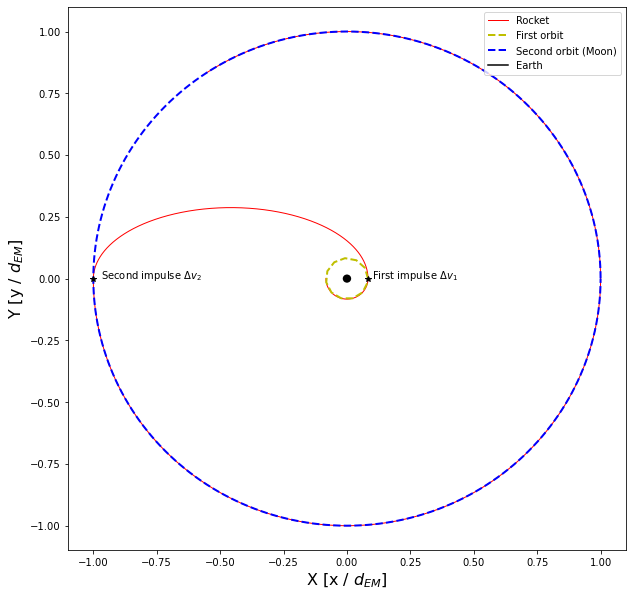

In [937]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

#Rocket
axes.plot(x_rocket, y_rocket, 'r', lw = 1, label = 'Rocket')

#First orbit
axes.plot(x_orbit, y_orbit,'y--', lw = 2,  label = 'First orbit')
axes.plot(0.083, 0, 'k*')
axes.annotate(r'First impulse $\Delta v_{1}$', (0.1, 0))

#Moon(second orbit)        
axes.plot(x_moon, y_moon,'b--', lw = 2,  label = 'Second orbit (Moon)')
axes.plot(-1, 0, 'k*')
axes.annotate(r'Second impulse $\Delta v_{2}$', (-0.97, 0))

#Earth
axes.plot(0,0, markersize = 0, c = 'black', label = 'Earth')  #Just to add the label
earth = [plt.Circle((0, 0), radius = 0.0166, linewidth=0)]
c_earth = matplotlib.collections.PatchCollection(earth, facecolors='Black')
axes.add_collection(c_earth)

if x_rocket.max() > y_rocket.max():

    axes.set_xlim(-1.1*x_rocket.max(),1.1*x_rocket.max())
    axes.set_ylim(-1.1*x_rocket.max(), 1.1*x_rocket.max())

else:
    axes.set_xlim(-1.1*y_rocket.max(),1.1*y_rocket.max())
    axes.set_ylim(-1.1*y_rocket.max(), 1.1*y_rocket.max())


axes.set_xlabel('X [x / $d_{EM}$]', fontsize = 16)
axes.set_ylabel('Y [y / $d_{EM}$]', fontsize = 16)
axes.set_xlim(-1.1,1.1)
axes.set_ylim(-1.1, 1.1)
axes.legend(loc = 'upper right')


plt.show()

We get the expected result. Let's compare this result with the one we get when not neglecting the mass of the moon.

In [938]:
# Initializing the variables
steps = 50000
h = 50


y1, y2, y3, y4 = np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1)
t = np.zeros(steps+1)

y1[0], y2[0], y3[0], y4[0], t_h, delta_v1, delta_v2 = initial_cond()

In [940]:
#Solving the equations
moon = True
first_pulse = 28335

t, y1, y2, y3, y4 = rungeKutta(t, y1, y2, y3, y4, h, steps, t_h, delta_v1, delta_v2,first_pulse,  moon)

In [941]:
x_rocket = y1*np.cos(y2)
y_rocket = y1*np.sin(y2)

w_first_orbit  = np.pi/28335
t_orbit = 2*pi/w_first_orbit
one_loop = int(t_orbit / h)

x_orbit = y1[0]*np.cos(t[:one_loop:100]*w_first_orbit)
y_orbit = y1[0]*np.sin(t[:one_loop:100]*w_first_orbit)

w = 2.6617*10**-6
t_moon = 2*pi/w
one_loop = int(t_moon / h)

x_moon = np.cos(t[:one_loop:200]*w)
y_moon = np.sin(t[:one_loop:200]*w)

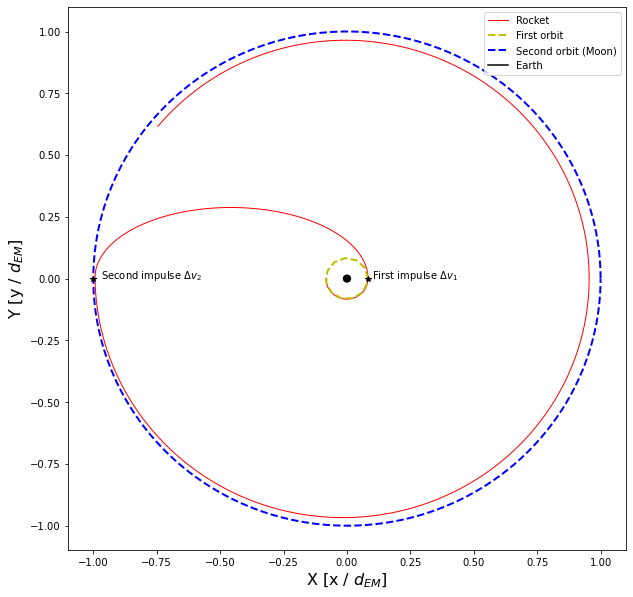

In [942]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

#Rocket
axes.plot(x_rocket, y_rocket, 'r', lw = 1, label = 'Rocket')

#First orbit
axes.plot(x_orbit, y_orbit,'y--', lw = 2,  label = 'First orbit')
axes.plot(0.083, 0, 'k*')
axes.annotate(r'First impulse $\Delta v_{1}$', (0.1, 0))

#Moon(second orbit)        
axes.plot(x_moon, y_moon,'b--', lw = 2,  label = 'Second orbit (Moon)')
axes.plot(-1, 0, 'k*')
axes.annotate(r'Second impulse $\Delta v_{2}$', (-0.97, 0))

#Earth
axes.plot(0,0, markersize = 0, c = 'black', label = 'Earth')  #Just to add the label
earth = [plt.Circle((0, 0), radius = 0.0166, linewidth=0)]
c_earth = matplotlib.collections.PatchCollection(earth, facecolors='Black')
axes.add_collection(c_earth)

if x_rocket.max() > y_rocket.max():

    axes.set_xlim(-1.1*x_rocket.max(),1.1*x_rocket.max())
    axes.set_ylim(-1.1*x_rocket.max(), 1.1*x_rocket.max())

else:
    axes.set_xlim(-1.1*y_rocket.max(),1.1*y_rocket.max())
    axes.set_ylim(-1.1*y_rocket.max(), 1.1*y_rocket.max())


axes.set_xlabel('X [x / $d_{EM}$]', fontsize = 16)
axes.set_ylabel('Y [y / $d_{EM}$]', fontsize = 16)
axes.set_xlim(-1.1,1.1)
axes.set_ylim(-1.1, 1.1)
axes.legend(loc = 'upper right')


plt.show()

In this case, the spacecraft does NOT transfer exactly onto the desired orbit. We reach an inner quasi-circular orbit. Because there is no analytical solution to the three body problem, we can't get an analytical Hohmann transfer orbit either. Nevertheless, for this type of cases, the Hohmann tranfer orbit is a very good approximation and only some small corrections are needed. 

In [1031]:
def initial_cond():
    
    '''
    r0 : the radial position of the rocket at time t=0
    phi : the angular position of the rocket in the surface of the Earth
    v0 : initial veolcity of the rocket
    theta : angular direction of the initial velocity
    '''
    #Some constants
    d_em = float(3.844e8)
    R_e = float(6.37816e6)
    R_m = float(1.734e6)
    G = float(6.67408e-11)
    M_e = float(5.9736e24)
    w = float(2.6617e-6)
    
    
    #Parameters of the Hohmann transfer orbit
    r1 = 5*R_e
    r2 = d_em*1.02
    t_h = np.pi * np.sqrt((r1 + r2)**3 / (8*G*M_e))
    delta_v1 = np.sqrt(G*M_e/r1)*(np.sqrt(2*r2/(r1 + r2)) - 1) / d_em
    delta_v2 = np.sqrt(G*M_e/r2)*(1 - np.sqrt(2*r1/(r1 + r2))) / d_em
    alfa = np.pi - w*t_h
    
    #The rocket is orbiting the Earth initially (circular orbit)
    phi = - alfa
    theta = phi + np.pi/2
    v0 = np.sqrt(G*M_e/r1) / d_em + delta_v1
    delta_v1 = 0

    #(y1, y2, y3, y4) = (r, phi, p_r,  p_phi)
    y1 = r1/d_em
    y2 = phi
    
    #With some trigonometry, one can prove that p_r and p_phi are
    y3 = v0*cos(theta-y2)
    y4 = y1*v0*sin(theta-y2)
       
    return y1, y2, y3, y4, t_h, delta_v1, delta_v2

In [1032]:
# Initializing the variables
steps = 8000
h = 70


y1, y2, y3, y4 = np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1), np.zeros(steps+1)
t = np.zeros(steps+1)

y1[0], y2[0], y3[0], y4[0], t_h, delta_v1, delta_v2 = initial_cond()

In [1033]:
#Solving the equations
moon = True
first_pulse = 0

t, y1, y2, y3, y4 = rungeKutta(t, y1, y2, y3, y4, h, steps, t_h, delta_v1, delta_v2, first_pulse, moon)

In [1034]:
x_rocket = y1*np.cos(y2)
y_rocket = y1*np.sin(y2)

w_first_orbit  = np.pi/28335
t_orbit = 2*pi/w_first_orbit
one_loop = int(t_orbit / h)

x_orbit = y1[0]*np.cos(t[:one_loop:100]*w_first_orbit)
y_orbit = y1[0]*np.sin(t[:one_loop:100]*w_first_orbit)

w = 2.6617*10**-6
t_moon = 2*pi/w
one_loop = int(t_moon / h)

x_moon = np.cos(t[:one_loop:200]*w)
y_moon = np.sin(t[:one_loop:200]*w)

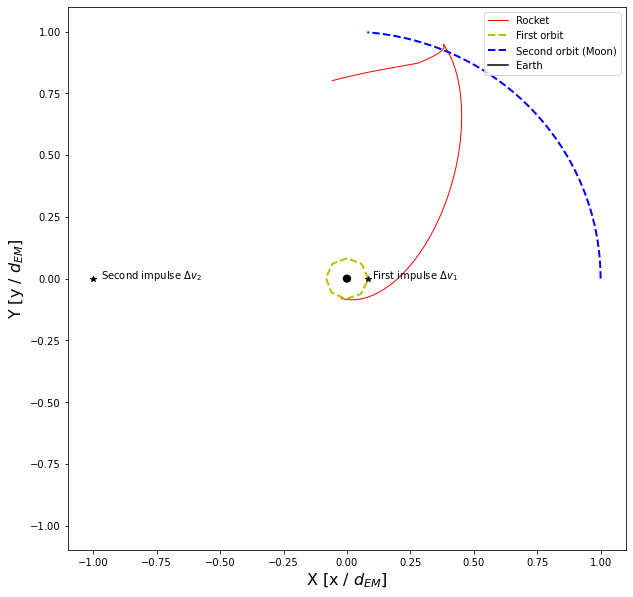

In [1035]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

#Rocket
axes.plot(x_rocket, y_rocket, 'r', lw = 1, label = 'Rocket')

#First orbit
axes.plot(x_orbit, y_orbit,'y--', lw = 2,  label = 'First orbit')
axes.plot(0.083, 0, 'k*')
axes.annotate(r'First impulse $\Delta v_{1}$', (0.1, 0))

#Moon(second orbit)        
axes.plot(x_moon, y_moon,'b--', lw = 2,  label = 'Second orbit (Moon)')
axes.plot(-1, 0, 'k*')
axes.annotate(r'Second impulse $\Delta v_{2}$', (-0.97, 0))

#Earth
axes.plot(0,0, markersize = 0, c = 'black', label = 'Earth')  #Just to add the label
earth = [plt.Circle((0, 0), radius = 0.0166, linewidth=0)]
c_earth = matplotlib.collections.PatchCollection(earth, facecolors='Black')
axes.add_collection(c_earth)

if x_rocket.max() > y_rocket.max():

    axes.set_xlim(-1.1*x_rocket.max(),1.1*x_rocket.max())
    axes.set_ylim(-1.1*x_rocket.max(), 1.1*x_rocket.max())

else:
    axes.set_xlim(-1.1*y_rocket.max(),1.1*y_rocket.max())
    axes.set_ylim(-1.1*y_rocket.max(), 1.1*y_rocket.max())


axes.set_xlabel('X [x / $d_{EM}$]', fontsize = 16)
axes.set_ylabel('Y [y / $d_{EM}$]', fontsize = 16)
axes.set_xlim(-1.1,1.1)
axes.set_ylim(-1.1, 1.1)
axes.legend(loc = 'upper right')


plt.show()

In [1036]:
# Animation

x_moon = np.cos(t*w)
y_moon = np.sin(t*w)
def make_animation():
    fig, axes = plt.subplots(1, 1, figsize=(10,10))
    speed = 50

    def animate(i):
        
        d_tl = float(3.844e8)
        R_t = float(6.37816e6)
        R_l = float(1.734e6)

        ax = axes
        ax.clear()
        
        #To jump some frames and make the animation faster
        speed = 50
        
        #To make Earth, moon and rocket bigger
        scale_factor = 5

        x_rock, y_rock = x_rocket[speed*i],y_rocket[speed*i]
        x_m, y_m = x_moon[speed*i], y_moon[speed*i]
        x_earth, y_earth = 0, 0
        
        
        #Plotting Earth, Moon and Rocket as a circles
        moon = [plt.Circle((x_m, y_m), radius=scale_factor*R_l/d_tl, linewidth=0)]
        earth = [plt.Circle((x_earth, y_earth), radius=scale_factor*R_t/d_tl, linewidth=0)]
        rocket = [plt.Circle((x_rock, y_rock), radius=scale_factor*0.5*R_l/d_tl, linewidth=0)]

        c_moon = matplotlib.collections.PatchCollection(moon, facecolors='grey')
        c_earth = matplotlib.collections.PatchCollection(earth, facecolors='blue')
        c_rocket = matplotlib.collections.PatchCollection(rocket, facecolors='black')

        ax.add_collection(c_rocket)
        ax.add_collection(c_moon)
        ax.add_collection(c_earth)
        
        #Axes limits
        if x_rocket.max() > y_rocket.max():
    
            ax.set_xlim(-1.1*x_rocket.max(),1.1*x_rocket.max())
            ax.set_ylim(-1.1*x_rocket.max(), 1.1*x_rocket.max())

        else:
            ax.set_xlim(-1.1*y_rocket.max(),1.1*y_rocket.max())
            ax.set_ylim(-1.1*y_rocket.max(), 1.1*y_rocket.max())
            
        axes.set_xlim(-1.3, 1.3)
        axes.set_ylim(-1.3, 1.3)

        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)

        ax.set_xlabel('X [1/$d_{EM}$]')
        ax.set_ylabel('Y [1/$d_{EM}$]')
        ax.set_title("Time = {} days".format(round(speed*i*h/(60*60*24), 2)))


        fig.tight_layout()

    ani = animation.FuncAnimation(fig, animate, frames=int(steps/speed), interval=1)
    ani.save(r'hohmann2.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


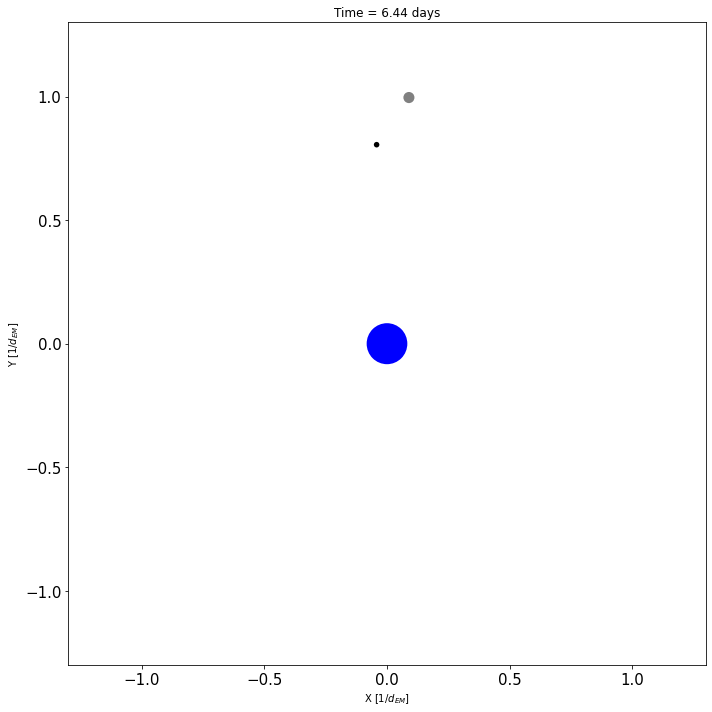

In [1037]:
make_animation()